# tt-nn Tracer Example

This notebook will show you how to use the components in `ttnn.tracer` to trace operations, and visualize it using `graphviz`.

It can help with debugging process and understanding how operations work in the ttnn library.

The API/uage is simple, so it should become a very invaluable tool during our explorations

## Dependencies and Setup

In order for the tracer to work we need to disable the fast runtime mode. This is done through setting an environment variable _before_ we import the `ttnn` library.

In [2]:
import os

os.environ["TTNN_CONFIG_OVERRIDES"] = "{\"enable_fast_runtime_mode\": false}"

Once the `enable_fast_runtime_mode` is disabled, we can import the `ttnn` library and use the tracer.

In [3]:

import ttnn
import torch
from ttnn.tracer import trace, visualize

2025-04-20 04:33:24.896 | DEBUG    | ttnn:<module>:80 - Loading ttnn configuration overrides from environment variable TTNN_CONFIG_OVERRIDES
2025-04-20 04:33:24.898 | DEBUG    | ttnn:<module>:83 - Initial ttnn.CONFIG:
Config{cache_path=/home/avgdev/.cache/ttnn,model_cache_path=/home/avgdev/.cache/ttnn/models,tmp_dir=/tmp/ttnn,enable_model_cache=false,enable_fast_runtime_mode=false,throw_exception_on_fallback=false,enable_logging=false,enable_graph_report=false,enable_detailed_buffer_report=false,enable_detailed_tensor_report=false,enable_comparison_mode=false,comparison_mode_should_raise_exception=false,comparison_mode_pcc=0.9999,root_report_path=generated/ttnn/reports,report_name=std::nullopt,std::nullopt}


## Example

Let's go back to our matrix multiplication example. We'll just trace the operation in multiplying 2 matrices and see what that looks like when visualized.

Create two simple matrices of (1, 2) and (2, 1) dimensions already in `TILE_LAYOUT`.

We can initialize the matrices under the `with trace():` context manager. Operations performed within will be traced and stored for visualization.

In [4]:
with trace():
  a = ttnn.from_torch(torch.tensor([[3, 3]]), dtype=ttnn.bfloat16, layout=ttnn.TILE_LAYOUT)
  b = ttnn.from_torch(torch.tensor([[5], [4]]), dtype=ttnn.bfloat16, layout=ttnn.TILE_LAYOUT)

                 Always | INFO     | Begin op: tt::tt_metal::detail::convert_python_tensor_to_tt_tensor
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<pybind11::handle const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<tt::tt_metal::DataType>>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<tt::tt_metal::Layout>>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<tt::tt_metal::Tile> const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::tt_metal::MemoryConfig const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::tt_metal::IDevice*>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<bool const>
            

We can run our first visualization of our tensor creation. Do that by calling `visualize` against the 2 tensors we have created. 

The graph will show that we create the `torch.Tensor` objects first, then convert them into `ttnn.Tensor` objects. We can see exactly what the properties of the `ttnn.Tensor` objects are. (shape, data type, layout, etc.)

2025-04-20 04:33:27.631 | DEBUG    | ttnn.tracer:visualize:443 - Dumping graph of the model to None
2025-04-20 04:33:27.634 | DEBUG    | ttnn.tracer:visualize:443 - Dumping graph of the model to None


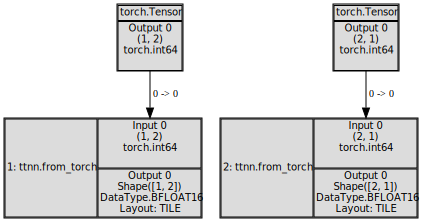

In [5]:

visualize(a)
visualize(b)

Initialize the device and store the handle to perform our operations on. 

In [6]:
device_id = 0
device = ttnn.open_device(device_id=device_id)

                 Device | INFO     | Opening user mode device driver
2025-04-20 04:33:29.483 | INFO     | SiliconDriver   - Opened PCI device 0; KMD version: 1.33.0, IOMMU: disabled

2025-04-20 04:33:29.494 | INFO     | SiliconDriver   - Opened PCI device 0; KMD version: 1.33.0, IOMMU: disabled
2025-04-20 04:33:29.496 | INFO     | SiliconDriver   - Harvesting mask for chip 0 is 0x200 (physical layout: 0x1, logical: 0x200, simulated harvesting mask: 0x0).
2025-04-20 04:33:29.497 | INFO     | SiliconDriver   - Opened PCI device 0; KMD version: 1.33.0, IOMMU: disabled
2025-04-20 04:33:29.497 | INFO     | SiliconDriver   - Detected PCI devices: [0]
2025-04-20 04:33:29.497 | INFO     | SiliconDriver   - Using local chip ids: {0} and remote chip ids {}
2025-04-20 04:33:29.524 | INFO     | SiliconDriver   - Software version 6.0.0, Ethernet FW version 6.14.0 (Device 0)
                  Metal | INFO     | Initializing device 0. Program cache is NOT enabled
                  Metal | INFO     | 

New chip! We now have 1 chips
Chip initialization complete (found )
Chip initializing complete...
 ARC

 [4/4] DRAM

 [16/16] ETH

 CPU

Chip detection complete (found )


Send the matrices to the device.

In [7]:
with trace():
  a = ttnn.to_device(a, device)
  b = ttnn.to_device(b, device)

                 Always | INFO     | Begin op: Tensor::to_device
                 Always | INFO     | Tensor doesn't have buffer, but storage is tt::tt_metal::OwnedStorage
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::tt_metal::IDevice*>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::tt_metal::MemoryConfig const>
                 Always | INFO     | End op: Tensor::to_device
                 Always | INFO     | Begin op: Tensor::to_device
                 Always | INFO     | Tensor doesn't have buffer, but storage is tt::tt_metal::OwnedStorage
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::tt_metal::IDevice*>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::tt_metal::MemoryConfig const>
                 Always | INFO     | End op: Tensor::to_device


Let's visualize it again. Notice how the visualization now shows movement from the host storage (CPU) to the device storage (ex. Wormhole).

We'll see a new property in nodes called "Memory". This is where the tensor is stored in the device. The device operates in `TILE` layout. 

2025-04-20 04:35:30.123 | DEBUG    | ttnn.tracer:visualize:443 - Dumping graph of the model to None
2025-04-20 04:35:30.126 | DEBUG    | ttnn.tracer:visualize:443 - Dumping graph of the model to None


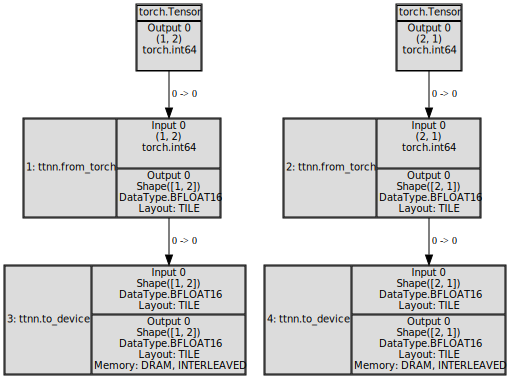

In [9]:
visualize(a)
visualize(b)

## Matrix Multiplication

Now we can just perform the matrix multiplication while visualizing the result.

In [10]:
with trace():
    c = ttnn.matmul(a, b)

                 Always | INFO     | Begin op: ttnn::matmul
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<bool const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<bool const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<tt::tt_metal::MemoryConfig const> const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<tt::tt_metal::DataType const> const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<std::__1::variant<ttnn::operations::matmul::MatmulMultiCoreProgramConfig, ttnn::operations::matmul::MatmulMultiCoreNonOptimizedReuseProgramConfig, ttnn::operations::matmul::MatmulMultiCoreReuseProgramConfig, ttnn::operations::matmul::MatmulMultiCoreReuseMultiCastProgramConfig, ttnn::operations::matmul::MatmulM

Seeing the visualization of the multiplication result is very interesting. You can see how `c` is originated from the 2 tensors `a` and `b`.

2025-04-20 04:39:02.264 | DEBUG    | ttnn.tracer:visualize:443 - Dumping graph of the model to None


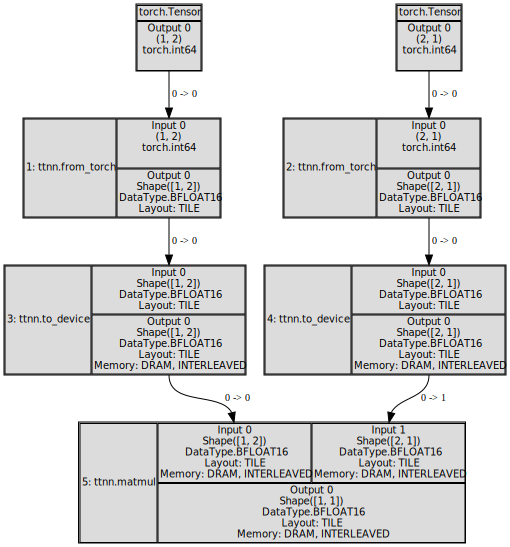

In [13]:
visualize(c)

## Clean Up

Close the device handle to clean up

In [7]:
ttnn.close_device(device)

                  Metal | INFO     | Closing device 0
                  Metal | INFO     | Disabling and clearing program cache on device 0
